## Let's Predict with Prophet and Google Analytics (GA)
GA is fantastic for generating time-series data to play with and can easily export a .csv file of revenue, users, and even a specific product, etc. by each day. Facebook's open source forecasting library, Prophet, can then use this data to help us predict what we might expect in the future for our target variable. 

**Here's how we'll tackle this:**

1.   Ask a question we'd like to predict for our eComm store..."how many new users? how much revenue? how many more sales of a specific product?"
2.   Set a time period for 1 - 5 years in GA and then export this as a .csv file
3. Load this .csv file into Google Drive or on our local machine for Google Colab to use. [Great article here on different options](https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/)
4. Format the columns and data types for Prophet
5. Leverage Prophet and the ML library *sklearn* to fit a linear model to our data. ([See Prophet documentation on a variety of options and examples for fitting your model](https://facebook.github.io/prophet/))
6. Visualize the data for insights around future values, shifts by day of week, etc
7. Fine tune our model with mean absolutee percentage error (MAPE) via this great article from [Towards Data Science](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)




In [ ]:
# Otherwise lots of noisy output
import warnings
warnings.filterwarnings('ignore')

# Common libraries
import pandas as pd
import json
import os
import numpy as np
from datetime import datetime, date, timedelta
import math
from sklearn.metrics import mean_absolute_error


# View more columns in output of Panda Dataframes
pd.set_option('display.max_columns', 500)

# Setup for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# Timeseries library from Facebook
from fbprophet import Prophet

# Prophet performance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


from pandas.plotting import scatter_matrix
import requests

## Step 1 - Segment the Data
First, let's grab a dataset from [Google Merchandise Store demo account](https://analytics.google.com/analytics/web/demoAccount) in Google Analytics to try and predict how many new users we might have in the coming years.[link text](https:// [link text](https:// [link text](https://)))*
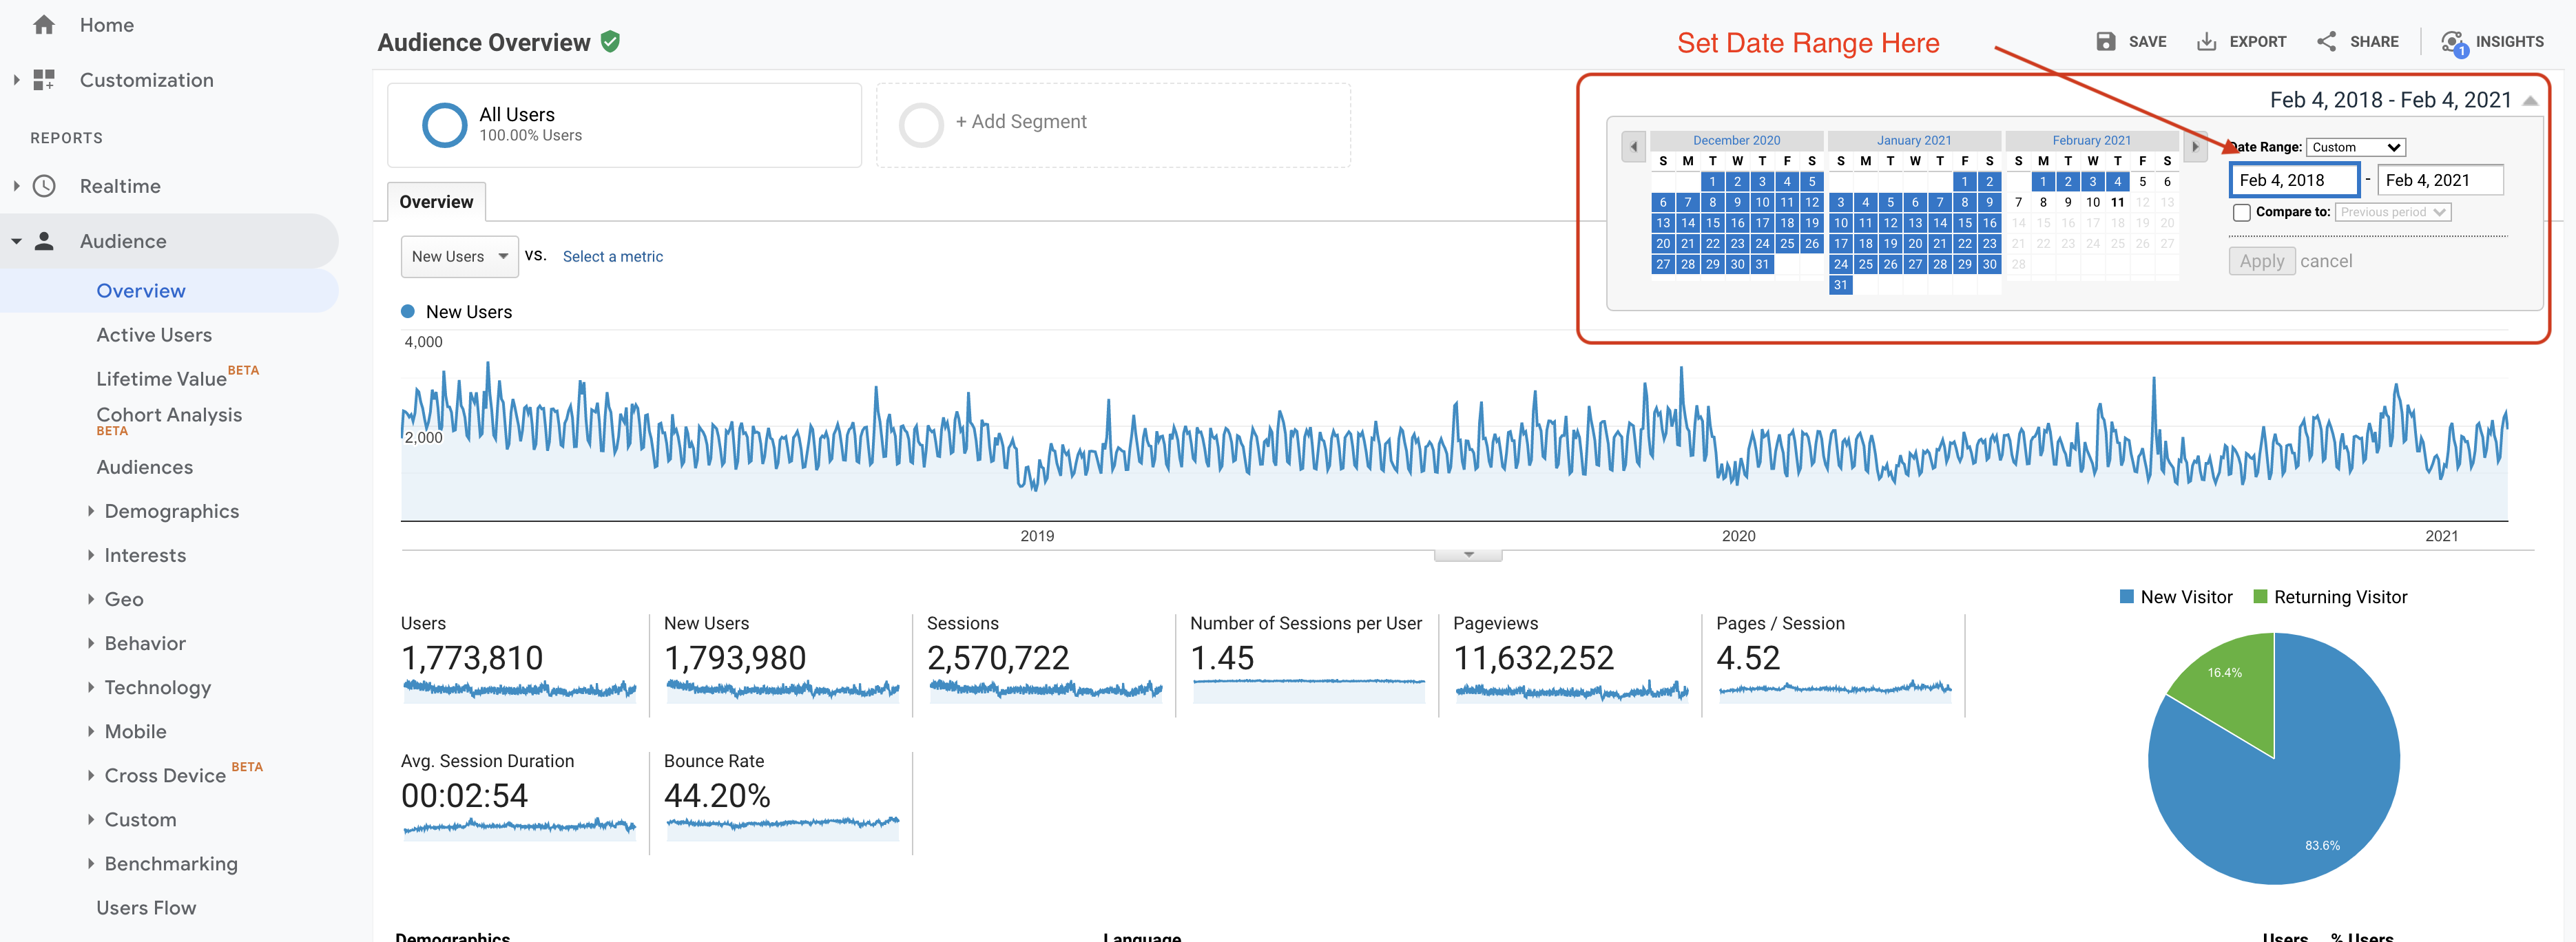

And then let's export this as a .csv file from GA:
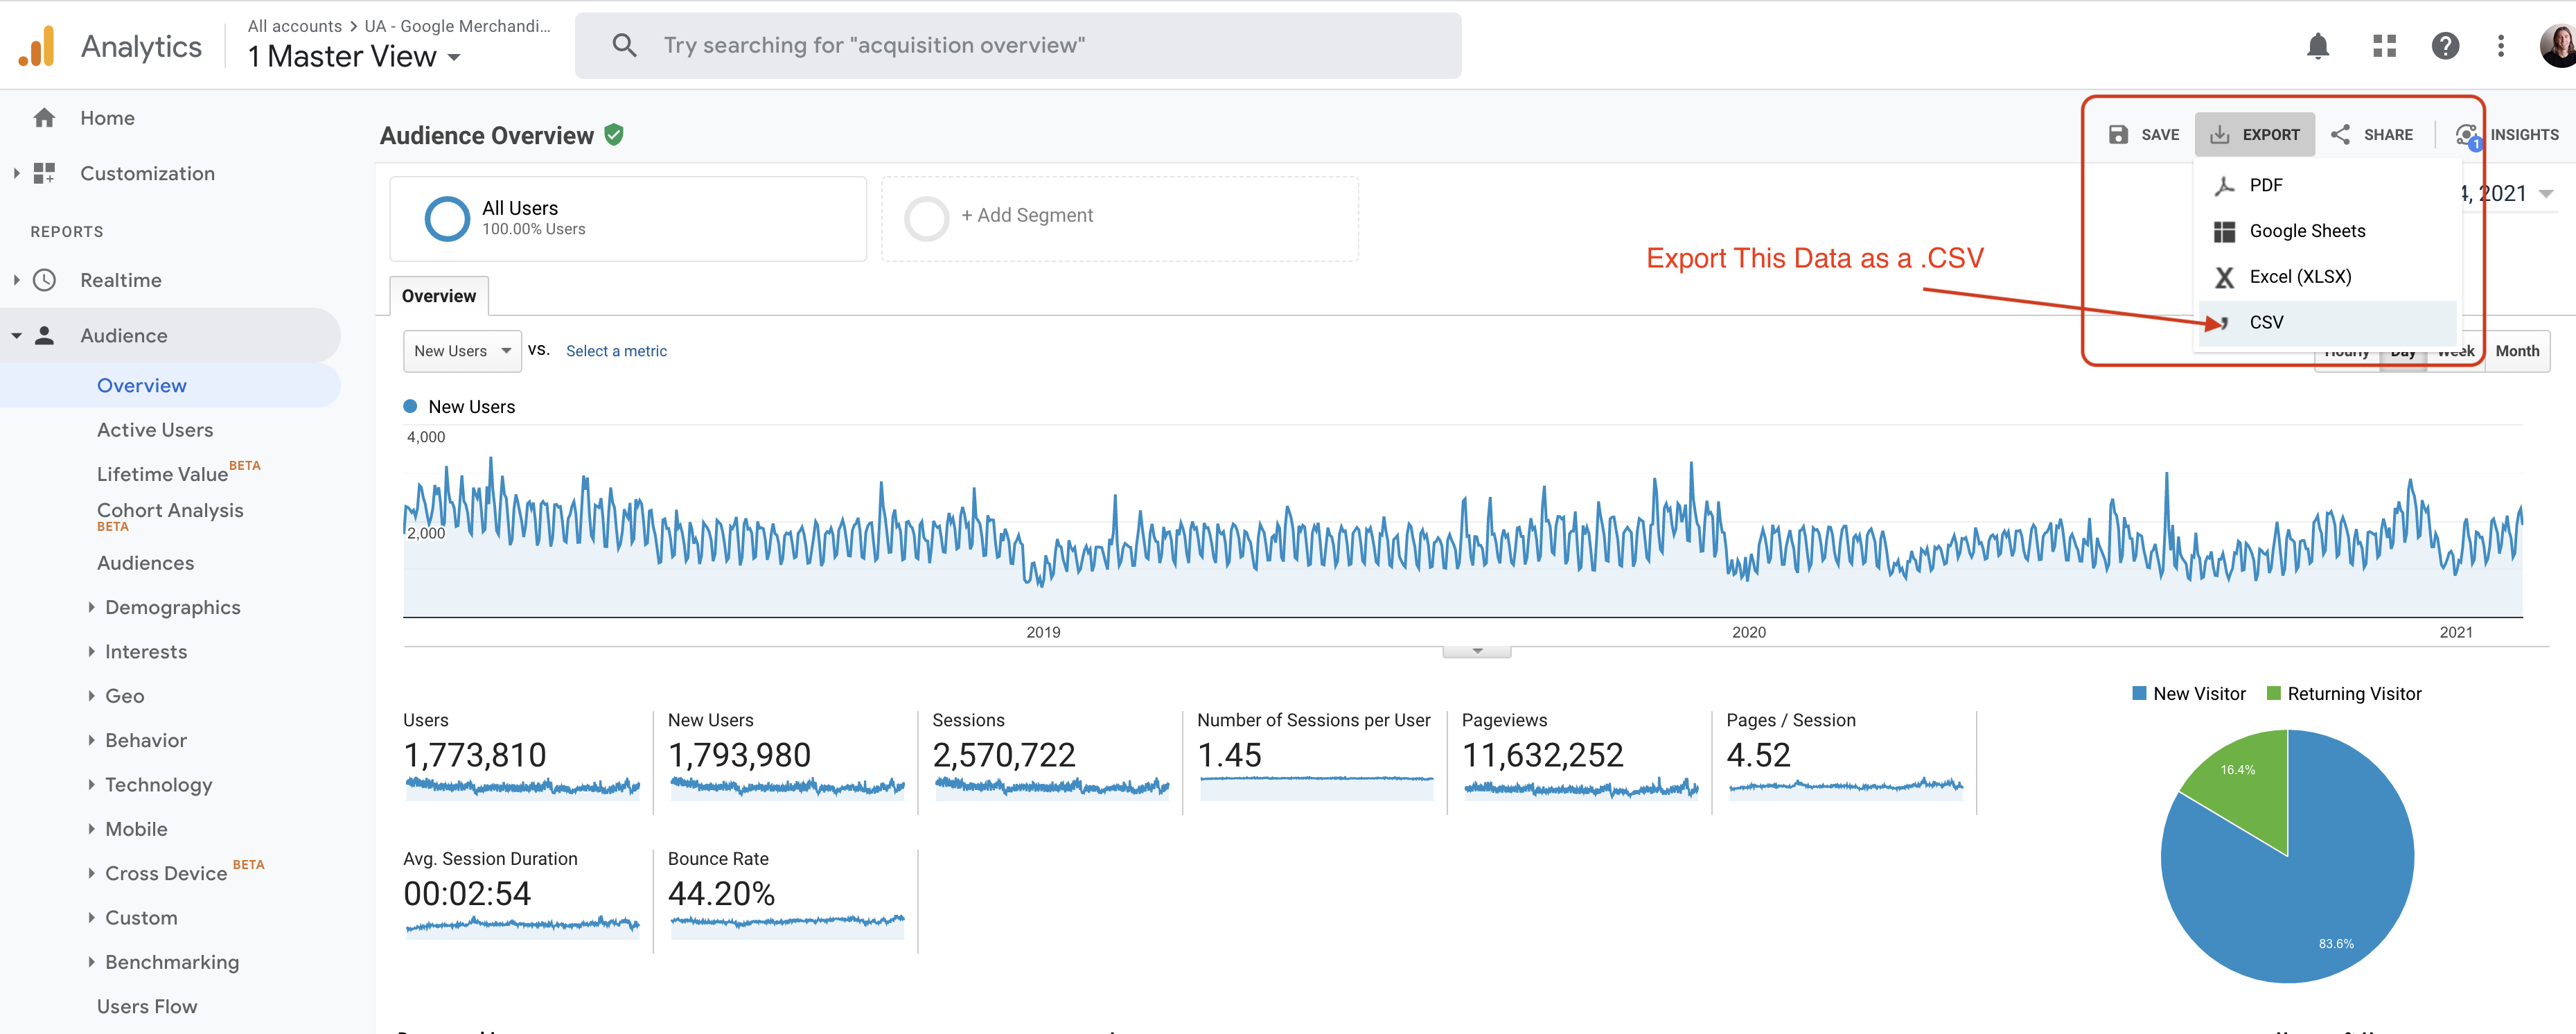

Finally, in Excel be sure to delete the first 6 rows so your .csv starts with just the column headings of "Day Index" and whatever you're analyzing (in this case "New Users")


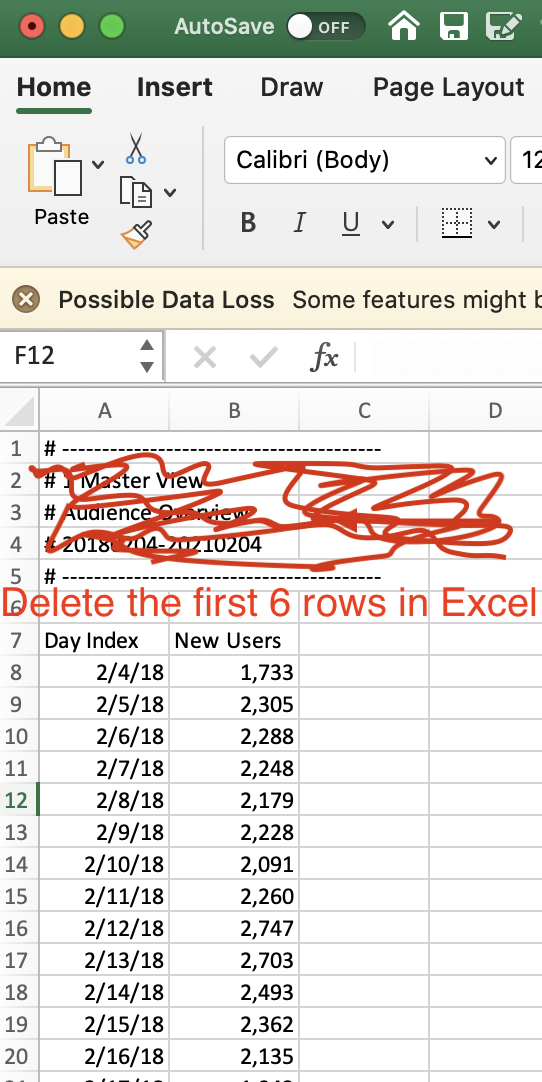

## Step 2 - Load & Transform the Data
There's a variety of ways for Google Colab to work with a .csv file using the Pandas library. Here, we're simply going to read the .csv file from a specific Google Drive folder we uploaded it to earlier.

In [ ]:
#Let's mount Google Drive to our Jupyter notebook for holding our .csv file
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#Let's setup a dataframe using Pandas to work our dataset of 36 mo for total new users from Google Merchandise Store which has already been loaded into a Drive folder online
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Product Notebooks/data/GoogMerch_36mo_newUsers.csv', encoding= 'unicode_escape', error_bad_lines=False)

#And let's take a quick peek at how the data came in using the .describe function on our dataframe's object
df.describe()

Mounted at /content/gdrive/


,Day Index,New Users
count,1097,1098
unique,1097,770
top,8/4/19,"1,827"
freq,1,5


In [ ]:
#Prophet is picky so we have to rename the columns headings as 'ds' and 'y' per the docs
df.columns = ['ds', 'y']

### IF USING INTEGERS WITH COMMAS IN YOUR DATASET ###
#reformatting columns with replace method 
df['y'].replace(',','', regex=True, inplace=True)

#Let's check to make sure our columns are correct using the .head function
df.head()

,ds,y
0,2018-02-04,1733
1,2018-02-05,2305
2,2018-02-06,2288
3,2018-02-07,2248
4,2018-02-08,2179


### Note - if you're trying to predict revenue! 
You'll need to convert the 'y' column to a float value for the data type for Prophet to work with it. Simply uncomment the code below and run this cell if your .csv has currency in it

In [ ]:
#Prophet is picky on how we format our data types so let's reformat
#Quick function for transforming currency values (if you're looking to predict revenue)

#def convert_currency(val):
 #   new_val = val.replace(',','').replace('$', '')
 #   return float(new_val)

#Applying this to our column 'y' which is our target variable to predict
#df['y'] = df['y'].apply(convert_currency)

In [ ]:
#Formatting the date time stamp to Prophet's specific ask of YY-mm-dd
df['ds'] = pd.to_datetime(df['ds'])

#Removing any NaN or missing values
df.dropna(inplace=True)

#One more quick check on the data format and column headings
df.head(5)

,ds,y
0,2018-02-04,1733
1,2018-02-05,2305
2,2018-02-06,2288
3,2018-02-07,2248
4,2018-02-08,2179
5,2018-02-09,2228
6,2018-02-10,2091
7,2018-02-11,2260
8,2018-02-12,2747
9,2018-02-13,2703


# Step 3 - Leverage Prophet
We're now ready to start to play with Prophet using our dataframe object we created and massaged.

In [ ]:
#We're going to start by fitting the model 'm' with a new Prophet object and set weekly seasonality as true
m = Prophet(weekly_seasonality=True)

#Next, we pass in our dataframe, 'df', we created above and call the fit method from Prophet library
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Let's build a dataframe to hold predictions for the next 3 years
# Using the handy make_future_dataframe method and setting this to a daily forecast for 3 years
future = m.make_future_dataframe(periods=365*3, freq='D')
future.tail()

,ds
2187,2024-01-31
2188,2024-02-01
2189,2024-02-02
2190,2024-02-03
2191,2024-02-04


In [ ]:
# Let's make some forecast predictions
# Passing in our dataframe we just built
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2187,2024-01-31,2552.395170,920.887049,4358.689167
2188,2024-02-01,2485.215531,813.071226,4307.243291
2189,2024-02-02,2282.995967,649.578140,4029.812299
2190,2024-02-03,1883.820022,148.915740,3626.809183
2191,2024-02-04,1919.692441,254.991063,3643.002973


<Figure size 1440x1440 with 0 Axes>

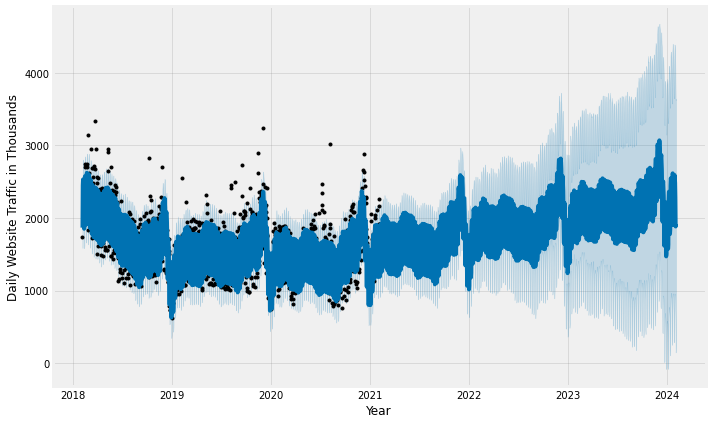

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# Plot our forecast 
fig1 = m.plot(forecast, xlabel='Year', ylabel='Daily Website Traffic in Thousands')
plt.figure(figsize=(20, 20))


### What the above graph tells us
The black dots represent the actual website traffic measurements we pulled from our Google Analytics account. Notice the seasonal swings?

The dark blue line is what Prophet forecasts going forward starting in 2021. The lighter blue lines indicate uncertainty levels (notice how these get wider in 2023 and 2024 as it gets harder to predict into the future with greater certainty)

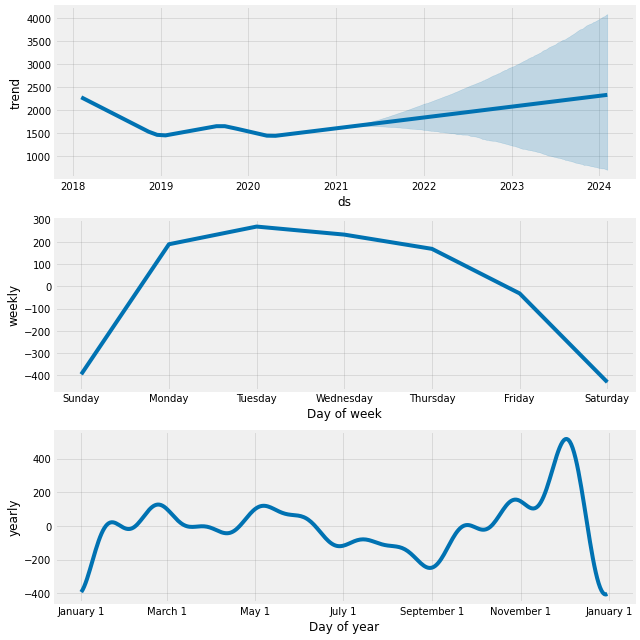

In [ ]:
# Using prophets ability to break down the elements of our forecast 
fig2 = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


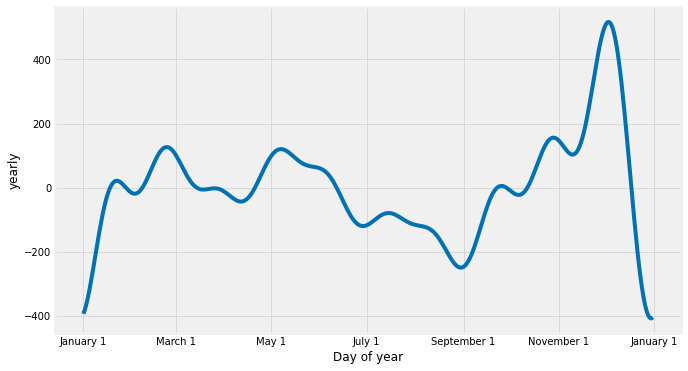

In [ ]:
from fbprophet.plot import plot_yearly
m = Prophet(weekly_seasonality=40).fit(df)
a = plot_yearly(m)

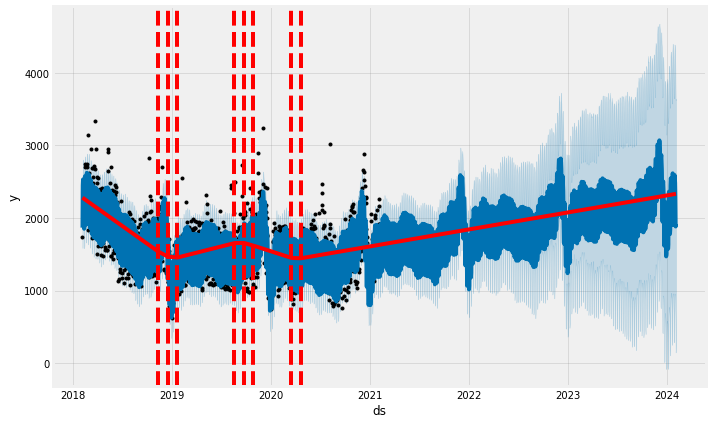

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
#help(Prophet)

## Fitting Our Model
Next, we'll use the Prophet functionality to cross validate and measure our forecast error using the historical data to answer the simple question of how well do our predictions line up? 

We can then use the mean absolute percentage error (MAPE) function to see our model performance in one number.

In [ ]:
# Here we use the cross validation function and set up our test/train splits
# First, we specificy forecast horizon (horizon) and the initial training period (initial)
# And finally, we specificy the cutoff dates (period)

# The 'cross_validation' function creates a fresh dataframe with true values of y and out-of-sample forecast values y-hat
# which basically means we're able to make a forecast for every observe point between cutoff and cutoff + horizon 
df_cv = cross_validation(m, initial='730 days', period='10 days', horizon='365 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-02-05 00:00:00 and 2020-02-05 00:00:00


In [ ]:
df_cv.tail()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
360,2021-01-31,1338.896680,1044.337363,1644.087889,1334,2020-02-05
361,2021-02-01,1970.956186,1654.669210,2273.585956,1924,2020-02-05
362,2021-02-02,2057.738761,1744.969430,2380.481310,2171,2020-02-05
363,2021-02-03,2026.147005,1716.300831,2340.737372,2257,2020-02-05
364,2021-02-04,1997.029869,1667.876245,2312.079683,1921,2020-02-05


In [ ]:
# Creating a new dataframe that includes our performance metrics
df_pm = performance_metrics(df_cv)
df_pm.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
325,361 days,49691.406754,222.915694,165.715224,0.124391,0.098977,0.861111
326,362 days,47918.443433,218.902817,159.881616,0.119155,0.088477,0.861111
327,363 days,46774.139484,216.273298,156.571411,0.115790,0.076847,0.861111
328,364 days,46082.169377,214.667579,155.215944,0.112981,0.076847,0.861111
329,365 days,43175.954263,207.788244,148.098123,0.106915,0.064353,0.888889


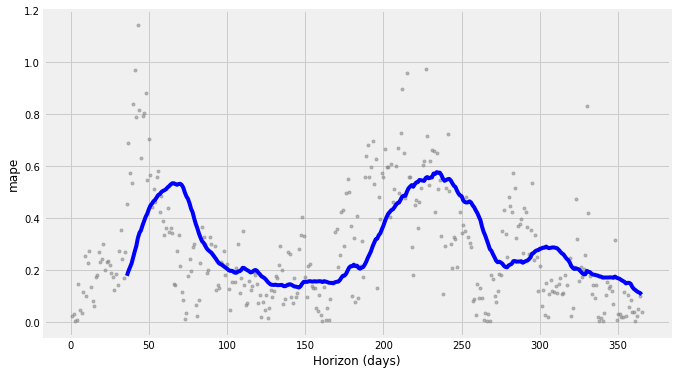

In [ ]:
# Plotting our predicted values against mean absolute percentage error
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Quick Recap
When we use 730 days for training and predict out for a year with spacing out every 10 days for cutoffs, we see the above graph. The sparseness is due to the fact that we're only running through two iterations on the model and correspondeingly our MAPE is actually pretty high as evidenced by the trend line and it fluctuating between ~20 - 60% for errors.

Let's start to tune a few basic parameters of the model to get a better prediction and lower our MAPE score.

In [ ]:
# Here we use the cross validation function and set up our test/train splits
# First, we specificy forecast horizon (horizon) and the initial training period (initial)
# And finally, we specificy the cutoff dates (period)
df_cv2 = cross_validation(m, initial='720 days', period='1 days', horizon='365 days')

INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-01-25 00:00:00 and 2020-02-05 00:00:00


In [ ]:
# Creating a new dataframe that includes our performance metrics
df_pm2 = performance_metrics(df_cv2)
df_pm2.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,78772.578179,280.664530,242.190630,0.164115,0.169426,0.420091
1,38 days,83996.946128,289.822266,251.697031,0.171443,0.182377,0.392694
2,39 days,89622.386384,299.369982,261.781220,0.179807,0.187293,0.365297
3,40 days,97188.220086,311.750253,273.537872,0.189832,0.194690,0.337900
4,41 days,107084.560042,327.237773,286.834510,0.201555,0.198082,0.310502


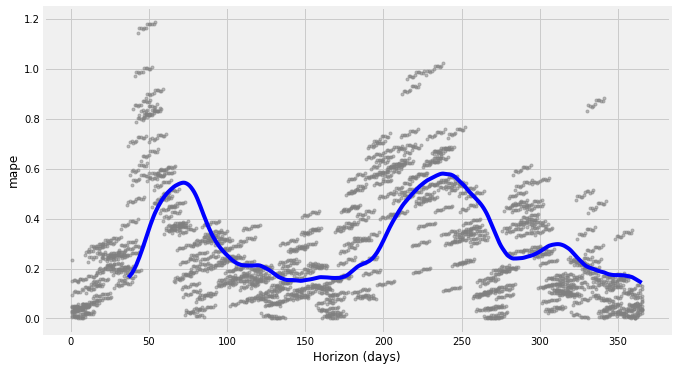

In [ ]:
# Plotting our predicted values against mean absolute percentage error
fig = plot_cross_validation_metric(df_cv2, metric='mape')